In [7]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import joblib


In [8]:
# Step 2: Load and Explore Data
df = pd.read_csv("Data.csv")

# Replace unknowns
df.replace(' ?', np.nan, inplace=True)

# Basic info
print(df.info())
print(df.describe())
print(df['income'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None
                age        fnlwgt  educational-num  capital-gain  \
cou

In [10]:
# Step 3: Handle Missing and Unknown Values
missing_cols = df.isnull().sum()
print("Missing values:\n", missing_cols[missing_cols > 0])

# Drop rows with missing values
df_clean = df.dropna()

print(f"Original Rows: {df.shape[0]} → Cleaned Rows: {df_clean.shape[0]}")


Missing values:
 Series([], dtype: int64)
Original Rows: 48842 → Cleaned Rows: 48842


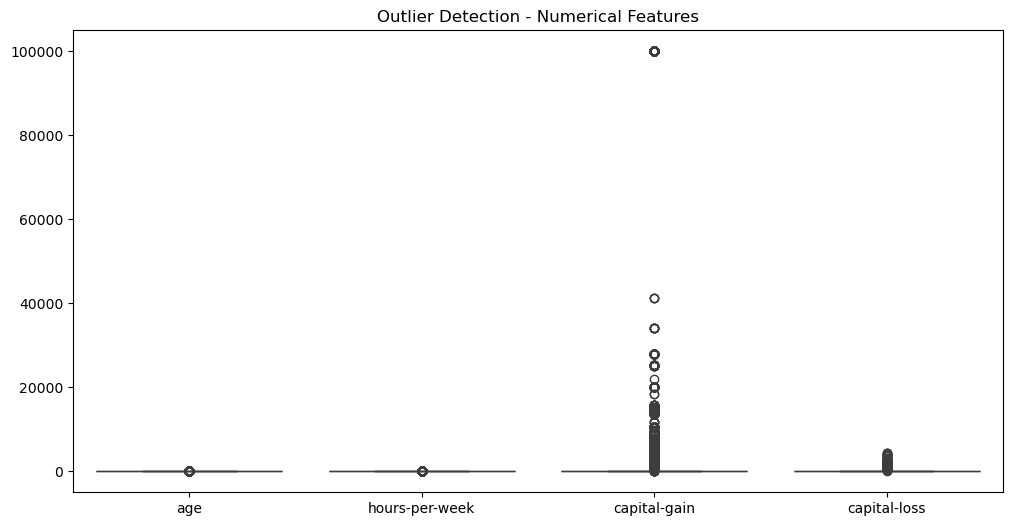

In [11]:
# Step 4: Explore and Remove Outliers
# Plotting boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[['age', 'hours-per-week', 'capital-gain', 'capital-loss']])
plt.title("Outlier Detection - Numerical Features")
plt.show()


In [12]:
# Step 5: Feature Cleanup
# Drop 'fnlwgt' (not useful)
df_clean = df_clean.drop(columns=['fnlwgt'])

# Optional: Combine similar or sparse classes if needed


In [13]:
# Step 6: Label Encoding
df_encoded = df_clean.copy()

label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

df_encoded.head()


,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,1,7,4,7,3,2,1,0,0,40,39,0
1,38,4,11,9,2,5,0,4,1,0,0,50,39,0
2,28,2,7,12,2,11,0,4,1,0,0,40,39,1
3,44,4,15,10,2,7,0,2,1,7688,0,40,39,1
4,18,0,15,10,4,0,3,4,0,0,0,30,39,0


In [14]:
# Step 7: Split Features and Labels
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Step 8: Train & Compare Models using Pipeline
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))



Logistic Regression Accuracy: 0.8270
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7479
           1       0.71      0.45      0.55      2290

    accuracy                           0.83      9769
   macro avg       0.78      0.70      0.72      9769
weighted avg       0.81      0.83      0.81      9769


Random Forest Accuracy: 0.8543
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      7479
           1       0.71      0.64      0.67      2290

    accuracy                           0.85      9769
   macro avg       0.80      0.78      0.79      9769
weighted avg       0.85      0.85      0.85      9769


SVM Accuracy: 0.8559
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7479
           1       0.76      0.57      0.65      2290

    accuracy                           0.86      9769
   macro avg       0.82      0.76   

<Axes: xlabel='hours-per-week', ylabel='Count'>

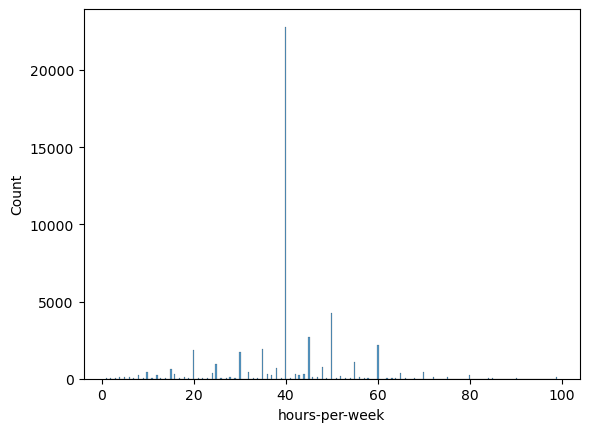

In [18]:
sns.histplot(df_clean['hours-per-week'])

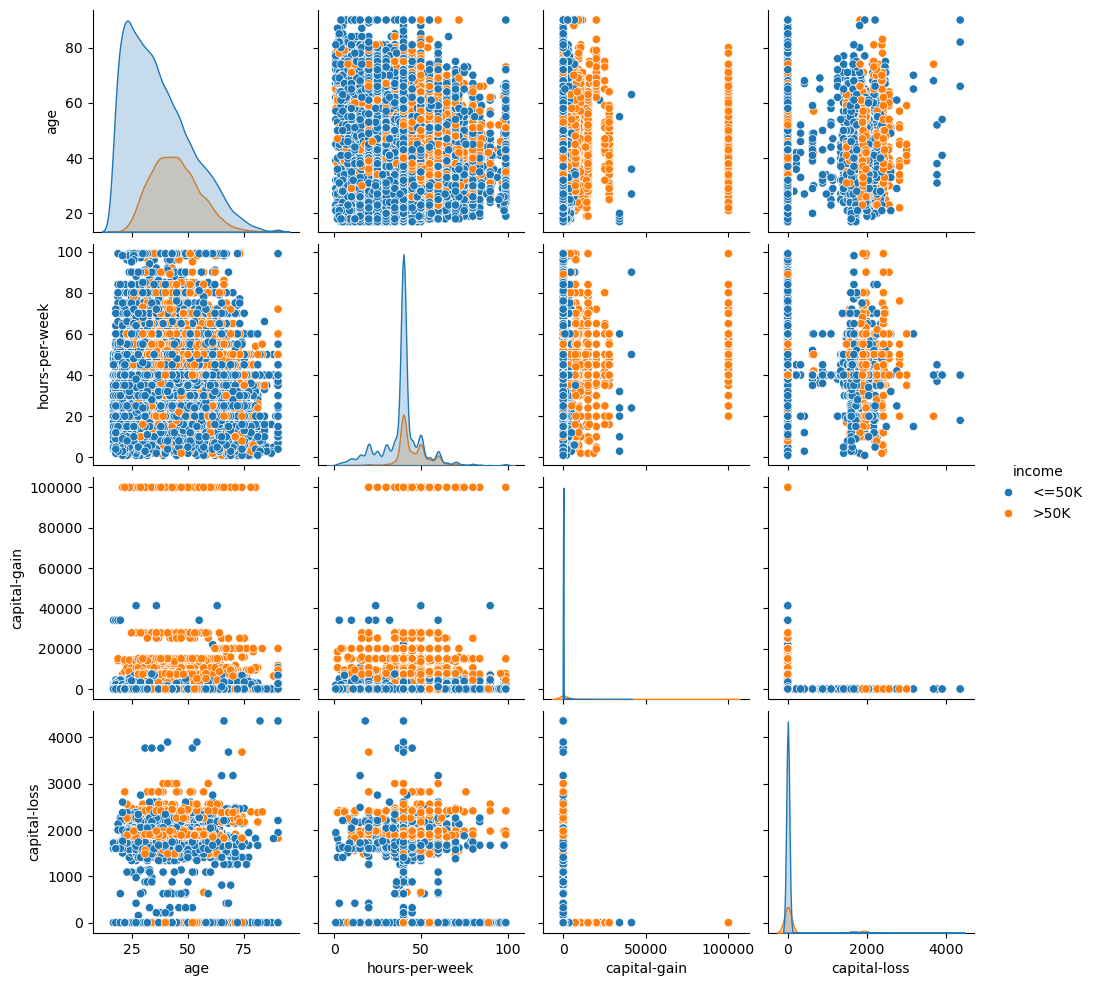

In [19]:
sns.pairplot(df_clean[['age', 'hours-per-week', 'capital-gain', 'capital-loss', 'income']], hue='income')

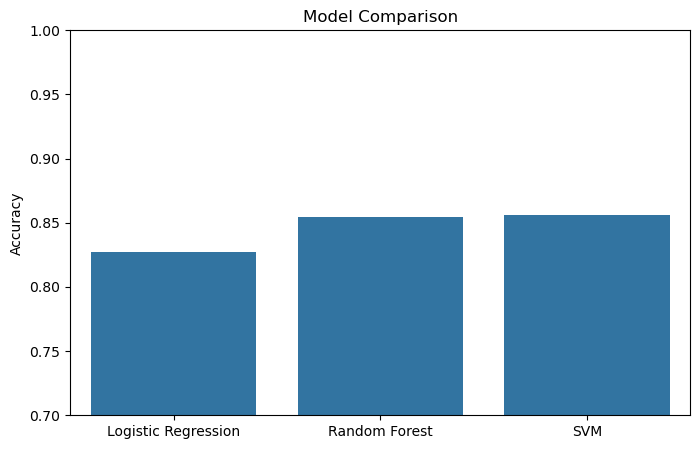

In [16]:
# Step 9: Visualize Model Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.ylim(0.7, 1.0)
plt.show()


In [23]:
#Step 10: Reuse X and y from earlier
final_svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))  # probability=True for Streamlit confidence
])

final_svm_model.fit(X, y)

# Save model and label encoders
joblib.dump(final_svm_model, 'svm_salary_model.joblib')
joblib.dump(label_encoders, 'label_encoders.joblib')

print("✅ Final SVM model saved successfully.")

✅ Final SVM model saved successfully.
